# Permutation Generation in PyTorch on GPU: Statistic Based Decision Rule for randperm vs. argsort and rand

<a name="outline"></a>
## Outline
This document provides an in-depth analysis of generating permutations in PyTorch, focusing on the performance and statistical properties of `torch.randperm` versus `torch.argsort` with `torch.rand` or `torch.randint`. The sections are summarized below:

1. **[Introduction](#intro)**: Discusses the basic functions `torch.randperm` and `torch.argsort` with `torch.rand` or `torch.randint`, highlighting their use cases and limitations.
2. **[Bias in Permutations Generated by `torch.argsort` with `torch.rand`](#bias-in-permutations)**: Explains the issue of biased distributions due to duplicate numbers in random arrays and how `torch.randperm` mitigates this problem.
3. **[Cost Criteria for Collisions when Using `argsort` with Randomly Generated Numbers](#cost-criteria)**: Introduces the concept of a cost criterion $P_{\text{crit}}$ and a decision rule for deciding which method to use based on permutation length and the number of bits in the random number generator.
4. **[Coin Toss Binomial Distribution Approximation as a Normal Distribution](#coin-toss-binomial)**: Models the problem using a binomial distribution and approximates it as a normal distribution to simplify calculations
5. **[Best Guess Criterion: Single Set of K Tosses](#best-guess-criterion-single)**: Gives the mathematical model for $P_{\text{crit}}(K; X)$ for a single permutation based on statistical analysis.
6. **[Best Guess Criterion: N Sets of K Tosses](#best-guess-criterion-multi)**: Extends the model to multiple permutations and derives bounds for the transition zone.
7. **[The Decision Rule](#decision-rule)**: Provides a practical decision rule for choosing the appropriate permutation generation method based on the analysis.
8. **[Additional Considerations](#additional-considerations)**: Discusses the simplification $\sigma_b \approx \sigma_f$, alternative criteria, and empirical testing for determining the effective number of bits in the float type.
9. **[Conclusion](#conclusion)**: Summarizes the findings and the practical guidelines derived from the analysis.

## TL;DR
If you want to quickly find the most critical information, go directly to the [Decision Rule](#decision-rule) section for practical guidelines on choosing between `torch.randperm` and `torch.argsort` with `torch.rand` or `torch.randint` for generating permutations in PyTorch.

<a name="intro"></a>
## 1. Introduction

The PyTorch library, widely used for neural networks on a GPU, supplies a function `torch.randperm(length)` that returns a permutation in a one-dimensional tensor, e.g.,
```python
>>> torch.randperm(6)
tensor([5, 3, 2, 4, 0, 1])
```
However, `torch.randperm` has a drawback - it cannot produce multiple permutations in batch mode. In PyTorch, batch mode refers to processing multiple inputs simultaneously, which improves performance.

A similar result can be obtained by using `torch.argsort` with `torch.rand` or `torch.randint`:
```python
>>> torch.argsort(torch.rand(6))
tensor([4, 3, 2, 5, 0, 1])
```
Unlike `torch.randperm`, `torch.argsort` with `torch.rand` or `torch.randint` can be used to produce a multidimensional tensor of permutations:
```python
# Create a batch of 3 permutations of length 6
>>> torch.argsort(torch.rand(3, 6))
tensor([[4, 3, 2, 5, 0, 1],
        [2, 5, 1, 0, 3, 4],
        [0, 3, 1, 5, 2, 4]])
```

The difference in speed becomes significant when utilizing a GPU to process tensors in parallel in a batch call, which may be faster per permutation by orders of magnitude. However, if there is no need to create multiple permutations or no need for speed, then using `randperm` is sufficient.

<a name="bias-in-permutations"></a>
## 2. Bias in Permutations Generated by `torch.argsort` with `torch.rand`

How does `torch.randperm` differ from and perform better than `torch.argsort(torch.rand...)`?

The issue is that among the arrays of random numbers produced by `torch.rand` and `torch.randint` are arrays that include duplicate numbers (also known as collisions). That, in turn, biases the distribution of permutations produced by sorting those arrays with `torch.sort`.

```python
>>> a = torch.randint(low=10, high=16, size=(6,))
tensor([11, 12, 15, 12, 11, 10])
>>> torch.sort(a, stable=True)
torch.return_types.sort(
values=tensor([10, 11, 11, 12, 12, 15]),
indices=tensor([5, 0, 4, 1, 3, 2]))
```

In the above example, the value of the parameter range `high - low` was set artificially low to 6 to induce duplicate values to be sorted. As a result, the sorted indices `0, 4`, corresponding to the duplicate sorted values `11, 11`, are arranged in ascending order (guaranteed by a stable sort, which maintains the relative order of equal elements). Likewise, indices `1, 3` are in ascending order. The resulting distribution of sorted indices is not symmetric because it is biased to have more ascending pairs than descending pairs, as a result of duplicates.

In contrast, the function `torch.randperm` is written to detect any duplicate keys and partially recalculate the results to remove the effects of those duplicate keys. The recalculation consists of regenerating keys for, and resorting only, those intervals with compromised values after the initial sort is complete. The result is almost perfect (excepting the tiny chance of the regenerated keys also having duplicates - it doesn't use a loop to eliminate that possibility). By using `torch.randperm`, the possibility of a biased distribution is (almost) eliminated.

<a name="cost-criteria"></a>
## 3. Cost Criteria for Collisions when Using `argsort` with Randomly Generated Numbers

The user generating multiple permutations of length $K$ must decide which form to use:
- A batch of permutations capable call to `argsort(rand...(batch_count, K))` which may have a biased result.
- Multiple single permutation only calls to `randperm(K)` which is (almost) unbiased.

Furthermore, the batch capable call may be any of these three forms:
- `argsort(rand(batch_count, K))` where the `rand` call returns values of type `torch.float32`, and uses a 24-bit random number generator.
- `argsort(randint(low=-(2^{31}-1), high=2^{31}-1), (batch_count, K), dtype=torch.int32)` where the `randint` call returns values of type `torch.int32` and uses a 32-bit random number generator (\*1).
- `argsort(randint(low=-(2^{63}-1), high=2^{63}-1), (batch_count, K), dtype=torch.int64)` where the `randint` call returns values of type `torch.int64` and uses a 64-bit random number generator (\*1).

> *\* Note 1: The PyTorch documentation for `randint` parameters says "high (int) – One above the highest integer to be drawn from the distribution." Therefore, we would expect the setting `high=2^{31}` to be appropriate. However, this has been found to lead to errors in some PyTorch versions.*

As will be shown, a higher number of bits in the random number generator will produce a less biased distribution of permutations. On the other hand, the `int64` bit version uses twice the memory as the `int32` bit version, allowing for less parallelization and thus being slower. Both `float32` and `int32` use the same amount of memory, but the `rand()` form of the call has been anecdotally seen to be a few percent faster than `randint()` with `int32` form, although this may vary by system.

Balancing all these considerations and putting them together in the form of a cost criterion $P_{\text{crit}}$ will allow for a decision rule with the form:

- if $P_{\text{crit}}(K; \text{float}) < C_{\text{thresh}}$
  - use the form `argsort(rand(batch_count, K))`
- else if $P_{\text{crit}}(K; \text{int32}) < C_{\text{thresh}}$
  - use the form `argsort(randint(low=-(2^{31}-1), high=2^{31}), (batch_count, K), dtype=torch.int32)`
- else if $P_{\text{crit}}(K; \text{int64}) < C_{\text{thresh}}$
  - use the form `argsort(randint(low=-(2^{63}-1), high=2^{63}), (batch_count, K), dtype=torch.int64)`
- else 
  - use the form `randperm(K)`

where 
- $K$ is the permutation length, fixed with respect to the decision rule,
- $P_{\text{crit}}(K; X)$ is a unified criterion depending on permutation length $K$ and $X \in \{\text{float}, \text{int32}, \text{int64}\}$,
- $C_{\text{thresh}}$ is a threshold on the value of $P_{\text{crit}}$, fixed within the decision rule, and is a free parameter set depending upon the application.
- $P_{\text{crit}}(K; X)$ increases monotonically with $X$, $X$ having the order $\{\text{float}, \text{int32}, \text{int64}\}$.

Section ["Best Guess Criterion: Single Set of K Tosses"](#best-guess-criterion-single) introduces the model for $P_{\text{crit}}(K; X)$ as described above.

Section ["Best Guess Criterion: N Sets of K Tosses"](#best-guess-criterion-multi) adds another parameter, $N$, to give $P_{\text{crit}}(K, N; X)$, where $N$ is the number of permutations whose joint distribution will be considered for bias. Like $K$, $N$ is always fixed with respect to the decision rule.

An obvious question is: *Why model a single permutation when the whole reason to use `argsort` with `random` instead of `randperm` is the advantage of batch production of permutations?*

The answer is that even in such cases, the criterion for a single degraded permutation may still be appropriate because it may be the cost/benefit ratio per permutation usage that is relevant.

The canonical counter-example would be, of course, the application of calculating the exact cost criterion over $N$ permutations.

Therefore, $N$ serves as another free parameter (in addition to $C_{\text{thresh}}$) that can be set appropriately per application.

<a name="coin-toss-binomial"></a>
## 4. Modeling Sorted Collisions as a Binomial of Coin Tosses with a Biased Coin

Consider the output of a call of torch.randperm(), assuming that it is a perfectly unbiased result. Because the indices in the result are unique, each adjacent pair is either ascending or descending. For our model, we will wrap the vector and count element pair $[K-1, 0]$ of the result as another pair, so that the number of adjacent pairs is $K$. (This is one too many, but it is convenient and a sufficient approximation). We can model this distribution of ascending and descending pairs as the binomial $(K, p)$ for $K$ coin tosses, where:

    an ascending pair is heads
    a descending pair is tails
    $p = \frac{1}{2}$ is the probability of heads

In the call torch.argsort(torch.rand...), argsort returns a tuple (values, indices) in which values is the sorted array and indices is the array of indices of the sorted array. This can likewise be modeled as a binomial $(K, q)$ for $K$ coin tosses

    ascending is heads
    descending is tails
    $q \geq \frac{1}{2}$ is the probability of heads
    $q - \frac{1}{2} \geq 0$ is the bias (towards heads) of a coin

For a single output length $K$ output by torch.rand(...), the expected number of collisions is:

$$ \begin{aligned} E[N_\text{collisions}] &= \frac{1}{2^m} \cdot \frac{K(K-1)}{2} \ &= \frac{K(K-1)}{2^{m+1}} \end{aligned} $$

where $K$ is the permutation length and $m$ is the number of bits in the random keys.

In Section X it was demonstrated that each collision of two values, after sorting, resulted in a forced ascending pair. Therefore, we decide to model the biased binomial probability $q$ as

$$ 
\begin{aligned} q &= \frac{E[N_\text{collisions}] + \frac{1}{2}(K - E[N_\text{collisions}])}{K}
&= \frac{1}{2} + \frac{(K-1)}{2^{m+2}}
\end{aligned} 
$$

so that the bias $d$ is

$$ 
\begin{aligned} d &= q - \frac{1}{2} \\
&= \frac{(K-1)}{2^{m+2}} 
\end{aligned} 
\tag{1} 
$$

This model has made the simplifying assumption that each collision corresponds to a single adjacent forced ascending pair. This is only true if no more than two occurrences of every unique value exist. That is the case in the example.

In actuality, we may have any number of occurrences up to $K$. A single value with $n$ occurrences would actually be counted as $\frac{n(n-1)}{2}$ collisions in equation 0.1, corresponding to an actual count of $n-1$ forced heads. However, our model would count $\frac{n(n-1)}{2}$ collisions as the same number $\frac{n(n-1)}{2}$ of forced heads.

Therefore, our model may overcount the number of forced heads. This is not an accuracy issue when three or more occurrences of the same value are rare. Furthermore, because it overestimates the number of heads, it overestimates the bias, which is safer than underestimating the bias.

### 4.1. From Binomal to a Continuous Approximation

The de Moivre–Laplace theorem states that the binomial distribution $(K, p)$ converges as $K \rightarrow \infty$ to the probability density function of the normal distribution with mean $Kp$ and variance $Kp(1-p)$. We will use that approximation.

For a fair coin:

$$
\sigma_f = \sqrt{\frac{K}{4}}
\tag{2}
$$

$$
\mu_f = \frac{K}{2}
\tag{3}
$$

$$
P_f(x) = \text{Normal}(x; \mu_f, \sigma_f)
$$

For a biased coin, $d \ne 0$:

$$
\begin{aligned}
\sigma_b &= \sqrt{K (\frac{1}{2}+d)(\frac{1}{2}-d)} \\
&= \sqrt{K \left(\frac{1}{4} - d^2\right)}
\end{aligned}
\tag{4}
$$

$$
\mu_b = K \left( \frac{1}{2} + d \right)
\tag{5}
$$

$$
P_b(x) = \text{Normal}(x; \mu_b, \sigma_b)
\tag{6}
$$

<a name="best-guess-criterion-single"></a>
## 5. Best Guess Criterion: Single Set of K Tosses

We assume a scenario where a guesser, who knows the value of $d$, observes the random variable $x$ and must guess whether it came from the "fair" or from the "biased" distribution. The guesser will always choose the distribution with the highest probability for $x$, which is

$$
\text{Best}(x) = \delta(P_b(x)>P_f(x)) 
$$

where $\delta(\cdot)$ is the indicator function that returns 1 if its argument is true and 0 otherwise.

While the guesser does not know the true distribution, we do know that the true distribution is the biased one. Therefore, the probability of a correct guess $P_{\text{crit}}$ is

$$
P_{\text{crit}} = \int \text{Best}(x) P_b(x) dx
\tag{7.pre1}
$$

At this point, we will make a simplifying assumption that $d^2$ is small enough that we can ignore it. This allows us to write:

$$
\begin{aligned}
P_b(x) &= \text{Normal}(x; \mu_b, \sigma_f)\\
&= P_b(x)
\end{aligned}
\tag{6.1}
$$

where $\sigma_f$ has replaced $\sigma_b$ in equation 6, since $\sigma_b = \sqrt{K\left(\frac{1}{4} - d^2\right)} \approx \sigma_f = \sqrt{\frac{K}{4}}$ when $d^2$ is small.

Then the best guess borderline is exactly at the midpoint between the two means, $\mu_f$ and $\mu_b$, because the normal distributions have equal variance.

Following from equation 7.pre1, the probability of a correct guess $P_{\text{crit}}$ is then:

$$
\begin{aligned}
P_{\text{crit}} &= \int_{\mu_f+\frac{\mu_b-\mu_f}{2}}^{\infty} P_b(x) dx \\
&= 1 - \text{cdf}(\mu_f+\frac{\mu_b-\mu_f}{2}; \mu_b, \sigma_f)\\
&= \text{cdf}(\mu_f+\frac{\mu_b-\mu_f}{2}; \mu_f, \sigma_f) \text{ (by symmetry of normal distribution)}\\
&= \text{cdf}(\frac{\mu_b-\mu_f}{2}; 0, \sigma_f) \text{ (by translation invariance)}\\
&= \text{cdf}(\frac{\mu_b-\mu_f}{2\sigma_f}; 0, 1) \text{ (by scaling invariance)}\\
\end{aligned}
\tag{7}
$$

where $\text{cdf}(x; \mu, \sigma)$ is the cumulative distribution function of the normal distribution with mean $\mu$ and standard deviation $\sigma$ evaluated at $x$.


The following plot illustrates how the probability of a correct guess can be calculated by integrating the area under the red curve (the biased coin) to the right of the vertical line (the best-guess cutoff at $0.25$). For the purposes of illustration, these arbitrary values are used: $\sigma_b = 0.5$, $\mu_f=0$, and $\mu_b = 0.5$.


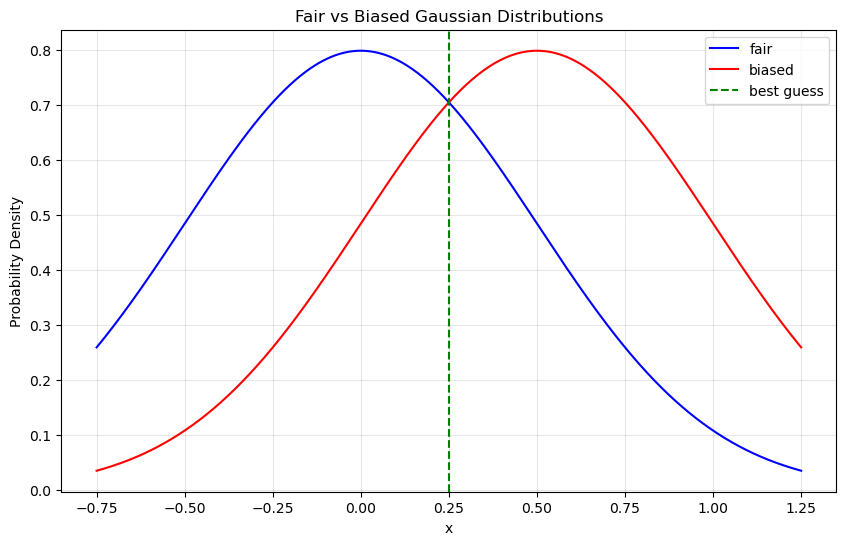

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
mean_f = 0      # mean for fair distribution
mean_b = 0.5    # mean for biased distribution
std = 0.5       # standard deviation (sqrt of variance 1/4)

# Create x values for plotting
x = np.linspace(-0.75, 1.25, 1000)

# Calculate y values for both Gaussian distributions
fair = np.exp(-(x - mean_f)**2 / (2 * std**2)) / (std * np.sqrt(2 * np.pi))
biased = np.exp(-(x - mean_b)**2 / (2 * std**2)) / (std * np.sqrt(2 * np.pi))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both Gaussian distributions
plt.plot(x, fair, 'b-', label='fair')
plt.plot(x, biased, 'r-', label='biased')

# Add vertical line at x=0.25
plt.axvline(x=0.25, color='g', linestyle='--', label='best guess')

# Add labels and title
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Fair vs Biased Gaussian Distributions')
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()



In the above graph, $P_{\text{crit}}$ is the area under the red curve to the right of the dashed green vertical line.

The higher $P_{\text{crit}}$, the more different the two distributions are, and the less suitable $P_b$ is as a substitute for $P_f$. With $P_{\text{crit}}$, when the bias is $0$, $P_{\text{crit}} = \frac{1}{2}$ because $P_f$ and $P_b$ are indistinguishable, and the best guess has only a $\frac{1}{2}$ probability of success. As the distributions become more distinguishable, $P_{\text{crit}}$ approaches $1$.


Substituting $\sigma_f$, $\mu_f$, and $\mu_b$ from equations 2, 3, and 5 to express $P_{\text{crit}}$ in terms of $K$ and $m$:

$$
\begin{aligned}
P_{\text{crit}} &= \text{cdf}(\frac{\mu_b-\mu_f}{2\sigma_f}; 0, 1)\\
&= \text{cdf}(\frac{Kd}{2\sqrt{K/4}}; 0, 1)\\
&= \text{cdf}(\sqrt{K}\ d; 0, 1)
\end{aligned}
\tag{9}
$$

Then substitute equation 1 for $d$:

$$
P_{\text{crit}}(K;m) = \text{cdf}(\frac{\sqrt{K}(K-1)}{2^{m+3}}; 0, 1)
\tag{9.1}
$$

The following table shows values of $P_{\text{crit}}$ listed for powers of 2 of $K$ (rows) versus number of effective bits in the call to random (columns). Those bit values are $m=24$ for float type, $m=32$ for 32-bit integer type, and $m=64$ for 64-bit integer type.


In [98]:
import statistics as stats
import math
from IPython.display import display, Markdown


def P_crit_aux(lnK, m):
    K = 2.0**lnK
    #sigma = math.sqrt(K)/2.0
    nd = stats.NormalDist(mu=0, sigma=1)
    arg = (math.sqrt(K)*(K-1.0))/(2.0**(m+3.0))
    return nd.cdf(arg)

def P_crit(lnK, m):
    x = P_crit_aux(lnK, m)
    if (x < 0.505):
        return "-"
    elif (x > 0.995):
        return "+"
    else:
        return f"{x:.2f}"

math_text = r"""
Table 1. $P_{{\text{{crit}}}}$ for various $K$, $m$ combinations.  Rows are $\log_2(K)$.  Columns are number of bits for float, integer32, and integer64 random numbers.
"""

display(Markdown(math_text))

md_text = f"""
| log2(K)/m | 24 | 32 | 64 |
| -- | -- | -- | -- |
"""
for lnK in range(4, 47, 1):
    md_text += f"| {lnK} | {P_crit(lnK, 24)} | {P_crit(lnK, 32)} | {P_crit(lnK, 64)} |\n"

display(Markdown(md_text))


Table 1. $P_{{\text{{crit}}}}$ for various $K$, $m$ combinations.  Rows are $\log_2(K)$.  Columns are number of bits for float, integer32, and integer64 random numbers.



| log2(K)/m | 24 | 32 | 64 |
| -- | -- | -- | -- |
| 4 | - | - | - |
| 5 | - | - | - |
| 6 | - | - | - |
| 7 | - | - | - |
| 8 | - | - | - |
| 9 | - | - | - |
| 10 | - | - | - |
| 11 | - | - | - |
| 12 | - | - | - |
| 13 | - | - | - |
| 14 | 0.51 | - | - |
| 15 | 0.52 | - | - |
| 16 | 0.55 | - | - |
| 17 | 0.64 | - | - |
| 18 | 0.84 | - | - |
| 19 | + | - | - |
| 20 | + | 0.51 | - |
| 21 | + | 0.54 | - |
| 22 | + | 0.60 | - |
| 23 | + | 0.76 | - |
| 24 | + | 0.98 | - |
| 25 | + | + | - |
| 26 | + | + | - |
| 27 | + | + | - |
| 28 | + | + | - |
| 29 | + | + | - |
| 30 | + | + | - |
| 31 | + | + | - |
| 32 | + | + | - |
| 33 | + | + | - |
| 34 | + | + | - |
| 35 | + | + | - |
| 36 | + | + | - |
| 37 | + | + | - |
| 38 | + | + | - |
| 39 | + | + | - |
| 40 | + | + | - |
| 41 | + | + | 0.51 |
| 42 | + | + | 0.52 |
| 43 | + | + | 0.57 |
| 44 | + | + | 0.69 |
| 45 | + | + | 0.92 |
| 46 | + | + | + |


The values for each column in Table 1 are divided into three zones which we may qualify as:

- safe, "-", $P_{\text{crit}}<0.505$
- transition, (number), $P_{\text{crit}}\geq0.505$ and $P_{\text{crit}}\leq0.995$
- unsafe, "+", $P_{\text{crit}}>0.995$

It can be seen that the safe zone and the unsafe zone are separated by a relatively short transition zone, which quickly transitions from safe to unsafe.

The bounds for $P_{\text{crit}} \in [0.505,0.995]$ were chosen to be inclusive of any reasonable choice for $P_{\text{crit}}$ with added margin.

Below we will use $P_{\text{crit}} \in [0.55,0.95]$ because $P_{\text{crit}}=0.95$ corresponds directly to the 95% confidence level, which by convention is chosen as the value beyond which the null hypothesis can be rejected in statistics. The value of $P_{\text{crit}}=0.55$ corresponds to a slight deviation from random guessing ($P_{\text{crit}}=0.5$) and was chosen for its symmetry with $P_{\text{crit}}=0.95$ in terms of detection confidence.

<a name="best-guess-criterion-multi"></a>
## 5. Best Guess Criterion: N Sets of K Tosses

Equation 1 for $d$ does not change at all. Independent of $N$, $d$ is always:

$$
d = \frac{K-1}{2^{m+2}}
\tag{1}
$$

However, equations 2, 3, 4, and 5 would change, with $K$ being replaced by the product $NK$.

For a fair coin:

$$
\sigma_f = \sqrt{\frac{NK}{4}}
\tag{2.N}
$$

$$
\mu_f = \frac{NK}{2}
\tag{3.N}
$$

For a biased coin, $d \ne 0$:

$$
\begin{aligned}
\sigma_b &= \sqrt{NK (\frac{1}{2}+d)(\frac{1}{2}-d)} \\
&= \sqrt{NK \left(\frac{1}{4} - d^2\right)}
\end{aligned}
\tag{4.N}
$$

$$
\mu_b = NK \left( \frac{1}{2} + d \right)
\tag{5.N}
$$

Substituting into equation 9:

$$
\begin{aligned}
P_{\text{crit}} &= \text{cdf}(\frac{NKd}{2}; 0, \frac{\sqrt{NK}}{2}) \\
&= \text{cdf}(\sqrt{NK}\ d; 0, 1)
\end{aligned}
\tag{9.N}
$$

Substituting for $d$:
$$
P_{\text{crit}} = \text{cdf}(\frac{\sqrt{NK}\ (K-1)}{2^{m+3}}; 0, 1)
$$

With $N > 1$, an exhaustive table such as Table 1 becomes inconvenient. Instead, we need to solve for the bounds of the transition zone iteratively for each value of $m \in \{24, 32, 64\}$, as shown in the following function `solve_ln2_K_for_P_crit_target(N, P_crit_targets)`.


In [99]:
from IPython.display import display, Markdown
from scipy.optimize import fsolve
import statistics
from typing import Tuple, List
import math

def equation_P_crit(ln2_K, ln2_N, m, P_crit_target):
    ln2_k = ln2_K[0] if hasattr(ln2_K, '__len__') else ln2_K # fsolve passes array for ln2_K to equation_best_guess
    K = 2.0**ln2_k
    N = 2.0**ln2_N
    nd = statistics.NormalDist(mu=0,sigma=1)
    arg = math.sqrt(N*K)*(K-1.0)/(2.0**(m+3.0))
    P_crit = nd.cdf(arg)
    return P_crit_target - P_crit
    
def solve_ln2_K_for_P_crit_target(ln2_N, P_crit_targets: List[float], eqn=None, verbose=False) -> List[Tuple[float, float]]:
    if (verbose):
        print(f"\nP_crit_targets = {P_crit_targets}, ln2_N={ln2_N:.6f}")
    N = 2.0**ln2_N
    
    ret = []
    for m in [24.0, 32.0, 64.0]:
        if verbose:
            print(f"\nFor m = {m}:")
        initial_guess_lnK = 0
        equation = eqn if eqn is not None else equation_P_crit
        try:
            lnkvals = []
            errs = []
            for i in range(0, len(P_crit_targets)):
                P_crit_target = P_crit_targets[i]
                # Select the first value of lnK which returns a negative 
                # error as the initial guess.
                for lnK in range(4, 47, 1):
                    r = equation(lnK, ln2_N, m, P_crit_target)
                    if r<0.0:
                        initial_guess_lnK = lnK
                        #print("initial_guess=", initial_guess_lnK)
                        break
                
                # Solve the equation
                solution, solution_info, success_flag, error_message = fsolve(
                    equation, 
                    x0=initial_guess_lnK, 
                    args=(ln2_N, m, P_crit_target), 
                    full_output=True,
                    factor=0.1,     # Smaller factor for smaller steps
                    xtol=1e-12,     # Tighter tolerance
                    maxfev=1000     # More iterations allowed
                )

                # Check if a valid solution was found
                if success_flag == 1:  # 1 indicates success
                    log2_K = float(solution[0])  # Get the first (and only) solution value
                    solution_error = float(solution_info['fvec'])
                    
                    # Store the results
                    errs.append(solution_error)
                    lnkvals.append(log2_K)
                    
                    if verbose:
                        print(f"Solution found for P_crit_target={P_crit_target}:")
                        print(f"  log2_K = {log2_K:.6f}")
                        print(f"  Error = {solution_error:.2e}")
                        print(f"  Function evaluations: {solution_info['nfev']}")
                else:
                    if verbose:
                        print(f"No solution found for P_crit_target={P_crit_target}. Error: {error_message}")

        except Exception as e:
            print(f"Error occurred: {str(e)}")

        if verbose:
            print(f"\nSummary for m = {m}:")
            # for i in range(0, 2):
            for i in range(0, len(P_crit_targets)):
                print(f"  P_crit_target={P_crit_targets[i]}: log2_K={lnkvals[i]:.6f}, error={errs[i]:.2e}")

        ret.append(lnkvals)
    return ret

def get_table(ln2_N: float, P_crit_target: float, verbose = False):
    r =  solve_ln2_K_for_P_crit_target(ln2_N=ln2_N, P_crit_targets=(P_crit_target,), verbose = False)
    return [x[0] for  x in r]

def print_lower_upper_table(ln2_N, P_crit_targets, verbose = False):
    data0 = get_table(ln2_N=ln2_N, P_crit_target=P_crit_targets[0], verbose = False)
    data1 = get_table(ln2_N=ln2_N, P_crit_target=P_crit_targets[1], verbose = False)

    md_table = f"""
*Table of ln2(K) bounds for transition zone, ln2(N)={ln2_N}, P_crit = {P_crit_targets}*
| m | lower bound | upper bound |
| -- | --         | --          |
| 24 | {data0[0]:.4f} | {data1[0]:.4f} |   
| 32 | {data0[1]:.4f} | {data1[1]:.4f} |   
| 64  | {data0[2]:.4f} | {data1[2]:.4f} |   
"""    
    display(Markdown(md_table))

for ln2_N in [0., 20., 40.]:
    P_crit_targets=(0.55,0.95)
    print_lower_upper_table(ln2_N, P_crit_targets, verbose = False)



*Table of ln2(K) bounds for transition zone, ln2(N)=0.0, P_crit = (0.55, 0.95)*
| m | lower bound | upper bound |
| -- | --         | --          |
| 24 | 16.0051 | 18.4786 |   
| 32 | 21.3384 | 23.8120 |   
| 64  | 42.6717 | 45.1453 |   



*Table of ln2(K) bounds for transition zone, ln2(N)=20.0, P_crit = (0.55, 0.95)*
| m | lower bound | upper bound |
| -- | --         | --          |
| 24 | 9.3399 | 11.8122 |   
| 32 | 14.6718 | 17.1453 |   
| 64  | 36.0051 | 38.4786 |   



*Table of ln2(K) bounds for transition zone, ln2(N)=40.0, P_crit = (0.55, 0.95)*
| m | lower bound | upper bound |
| -- | --         | --          |
| 24 | 2.8187 | 5.1724 |   
| 32 | 8.0088 | 10.4793 |   
| 64  | 29.3384 | 31.8120 |   


We can use `solve_ln2_K_for_P_crit_target(N, P_crit_targets: tuple)` to plot a graph of the $\log_2(K)$ lower and upper limits of the transition zone on a graph with $\log_2(N)$ as the range.

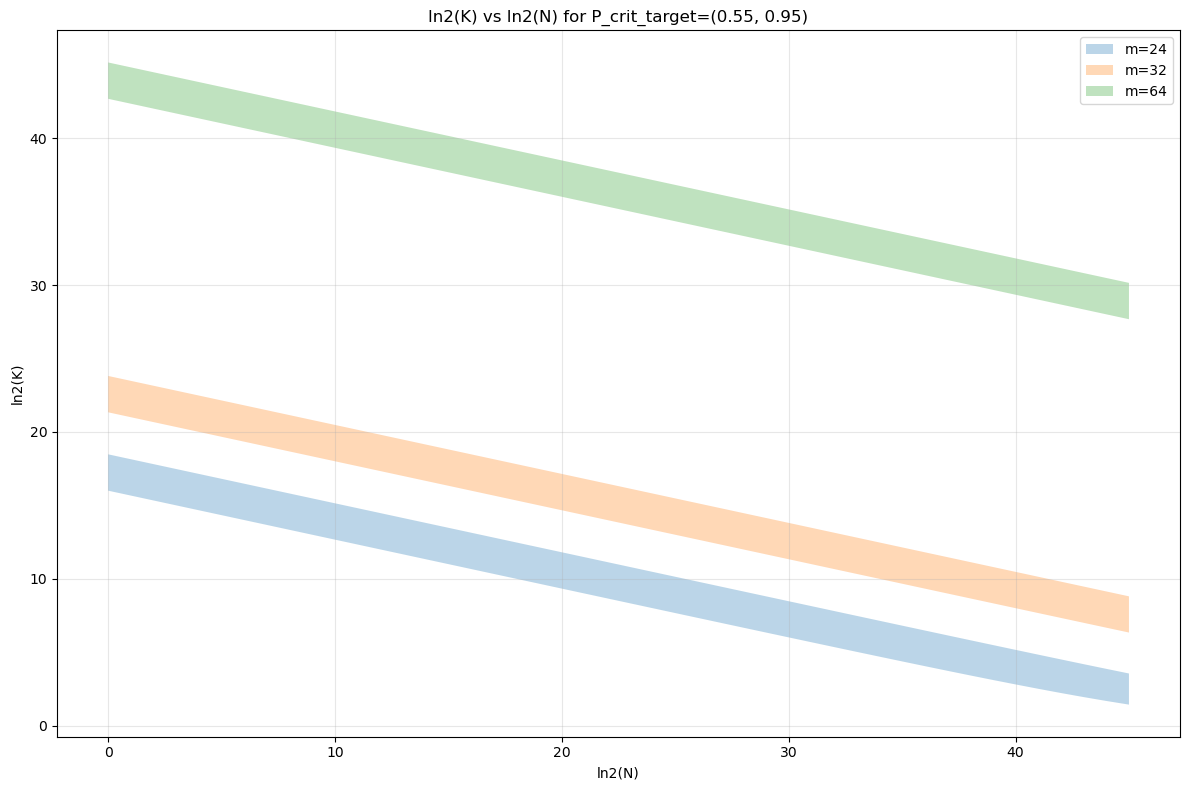

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lnK_results(P_crit_targets: tuple):
    # Create x-axis values (ln2_N from 0 to 45)
    ln2_N_values = np.linspace(0, 45, 46)  # 46 points to include both 0 and 45
    
    # Lists to store results for each m value
    results_m24 = []
    results_m32 = []
    results_m64 = []
    
    # Calculate results for each ln2_N
    for ln2_N in ln2_N_values:
        m24, m32, m64 = solve_ln2_K_for_P_crit_target(ln2_N, P_crit_targets, verbose=False)
        results_m24.append(m24)
        results_m32.append(m32)
        results_m64.append(m64)
    
    # Convert results to numpy arrays for easier manipulation
    results_m24 = np.array(results_m24)
    results_m32 = np.array(results_m32)
    results_m64 = np.array(results_m64)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each set of results
    plt.fill_between(ln2_N_values, 
                    [r[0] for r in results_m24], 
                    [r[1] for r in results_m24], 
                    alpha=0.3, label='m=24')
    
    plt.fill_between(ln2_N_values, 
                    [r[0] for r in results_m32], 
                    [r[1] for r in results_m32], 
                    alpha=0.3, label='m=32')
    
    plt.fill_between(ln2_N_values, 
                    [r[0] for r in results_m64], 
                    [r[1] for r in results_m64], 
                    alpha=0.3, label='m=64')
    
    # Customize the plot
    plt.xlabel('ln2(N)')
    plt.ylabel('ln2(K)')
    plt.title(f'ln2(K) vs ln2(N) for P_crit_target={P_crit_targets}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function with updated P_crit_targets values
plot_lnK_results(P_crit_targets=(0.55, 0.95))

The relation between $\log_2(K)$ and $\log_2(N)$ appears to be nearly linear for all bands in the range $\log_2(N) \in [0,30]$. The lowest band $m=24$ is clearly running out of room somewhere above $30$. We will analyze and confirm the accuracy of this linearity in the following function:

In [101]:
import numpy as np
from scipy import stats
from typing import Tuple, List
from IPython.display import display, Markdown

C_thresh_lo = 0.55
C_thresh_hi = 0.95
def analyze_linear_relationships(solve_ln2_K_for_P_crit_target, start=0, end=40, num_points=31):
    # Generate input points
    ln2_N_values = np.linspace(start, end, num_points)
    
    # Initialize arrays to store results
    results = np.zeros((num_points, 6))  # 6 dimensions from 3 pairs of tuples
    
    # Collect results
    for i, ln2_N in enumerate(ln2_N_values):
        # Changed from (0.1, 0.9) to (0.55, 0.95)
        result = solve_ln2_K_for_P_crit_target(ln2_N, (0.55, 0.95))
        # Flatten the result into 6 dimensions
        results[i] = [result[0][0], result[0][1], 
                     result[1][0], result[1][1],
                     result[2][0], result[2][1]]
                         
    # Perform linear regression for each dimension
    slopes = []
    intercepts = []
    r_values = []
    
    for dim in range(6):
        slope, intercept, r_value, _, _ = stats.linregress(ln2_N_values, results[:, dim])
        slopes.append(slope)
        intercepts.append(intercept)
        r_values.append(r_value)
    
    # Analyze slopes for outliers
    slope_mean = np.mean(slopes)
    slope_std = np.std(slopes)
    
    # Create markdown output
    markdown_output = f"""
### Linear Regression Analysis Results  
 
We examined the sloped form the solutions 
- P_crit_target_low = {C_thresh_lo} 
- P_crit_target_high = {C_thresh_hi}
for each of $m = 24,32,64$.

### Summary Statistics for Slopes, Range of log2(N)= [{start},{end}]
- Mean slope: {slope_mean:.6f}
- Standard deviation: {slope_std:.6f}

### Individual Dimension Results
| Dimension | Slope | R² | Intercept | Z-score | Outlier? |
|-----------|-------|-----|-----------|----------|----------|
"""
    
    # Labels for each dimension
    dim_labels = [
        "m=24.0 ( P_crit_target_low)", "m=24.0 ( P_crit_target_high)",
        "m=32.0 ( P_crit_target_low)", "m=32.0 (P_crit_target_high)",
        "m=64.0 ( P_crit_target_low)", "m=64.0 (P_crit_target_high)"
    ]
    
    # Add results for each dimension
    for dim in range(6):
        z_score = (slopes[dim] - slope_mean) / slope_std
        is_outlier = abs(z_score) > 2  # Using 2 standard deviations as threshold
        
        markdown_output += f"| {dim_labels[dim]} | {slopes[dim]:.6f} | {r_values[dim]**2:.6f} | {intercepts[dim]:.6f} | {z_score:.2f} | {'Yes' if is_outlier else 'No'} |\n"
    
    # Add interpretation
    markdown_output += "\n### Interpretation\n"
    markdown_output += "- R² values close to 1.0 indicate strong linear relationships\n"
    markdown_output += "- Z-scores > |2| are considered potential outliers\n"
    markdown_output += f"- Coefficient of Variation: {(slope_std/slope_mean)*100:.2f}%\n"
    
    display(Markdown(markdown_output))
    
    return slopes, intercepts, r_values

# Example usage:
slopes, intercepts, r_values = analyze_linear_relationships(solve_ln2_K_for_P_crit_target, 0, 30)


### Linear Regression Analysis Results  
 
We examined the sloped form the solutions 
- P_crit_target_low = 0.55 
- P_crit_target_high = 0.95
for each of $m = 24,32,64$.

### Summary Statistics for Slopes, Range of log2(N)= [0,30]
- Mean slope: -0.333268
- Standard deviation: 0.000118

### Individual Dimension Results
| Dimension | Slope | R² | Intercept | Z-score | Outlier? |
|-----------|-------|-----|-----------|----------|----------|
| m=24.0 ( P_crit_target_low) | -0.333007 | 0.999999 | 16.002517 | 2.20 | Yes |
| m=24.0 ( P_crit_target_high) | -0.333274 | 1.000000 | 18.478178 | -0.06 | No |
| m=32.0 ( P_crit_target_low) | -0.333325 | 1.000000 | 21.338345 | -0.49 | No |
| m=32.0 (P_crit_target_high) | -0.333332 | 1.000000 | 23.811961 | -0.54 | No |
| m=64.0 ( P_crit_target_low) | -0.333333 | 1.000000 | 42.671742 | -0.56 | No |
| m=64.0 (P_crit_target_high) | -0.333333 | 1.000000 | 45.145306 | -0.56 | No |

### Interpretation
- R² values close to 1.0 indicate strong linear relationships
- Z-scores > |2| are considered potential outliers
- Coefficient of Variation: -0.04%


Notice the $\log_2(K)$ intercepts are within $\frac{3}{1000}$ of the $N=1$, $P_{\text{crit\\_target}} = 0.55$ result reprinted here:

In [102]:
r = get_table(0., 0.55, verbose = False)
md = f"""
| m | $\log_2(K)$ |
| -- | -- |
"""
for i in [0,1,2]:
    md += f"|{[24,32,64][i]}|{r[i]}|\n"
display(Markdown(md))


| m | $\log_2(K)$ |
| -- | -- |
|24|16.00508985987189|
|32|21.338408931655618|
|64|42.671741902260145|


The slope is sufficiently close to $-\frac{1}{3}$ that it can be used in the final decision rule.

<a name="decision-rule"></a>
## 6. The Decision Rule

We will set the target $P_{\text{crit}} = 0.55$. For the case of $N=1$, the decision rule is:

- if $\log_2(K) < 16.005$
  - use the form `argsort(rand(batch_count, K))`
- else if $\log_2(K) < 21.338$
  - use the form `argsort(randint(low=-(2^{31}-1), high=2^{31}), (batch_count, K), dtype=torch.int32)`
- else if $\log_2(K) < 42.672$
  - use the form `argsort(randint(low=-(2^{63}-1), high=2^{63}), (batch_count, K), dtype=torch.int64)`
- else 
  - use the form `randperm(K)`

In case the free parameter $N$ is greater than 1, the decision rule is:

- if $\log_2(K) < 16.005 - \frac{\log_2(N)}{3}$
  - use the form `argsort(rand(batch_count, K))`
- else if $\log_2(K) < 21.338 - \frac{\log_2(N)}{3}$
  - use the form `argsort(randint(low=-(2^{31}-1), high=2^{31}), (batch_count, K), dtype=torch.int32)`
- else if $\log_2(K) < 42.672 - \frac{\log_2(N)}{3}$
  - use the form `argsort(randint(low=-(2^{63}-1), high=2^{63}), (batch_count, K), dtype=torch.int64)`
- else 
  - use the form `randperm(K)`


<a name="additional-considerations"></a>
## 7. Additional Considerations

### $d^2$ is small for the solution $P_{\text{crit}}=0.55$

Our decision to use the simplification $\sigma_b \approx \sigma_f$ in equation 6.1 was conditioned on $d^2$ having a very small value, where $d$ is given in equation 1. The following table shows that for the case of $N=1$, the values of $d^2$ are indeed very small, and that the simplification is justified.

In [103]:
r = get_table(0., 0.55, verbose = False)
md = f"""
| $m$ | $\log_2(K)$ | $d$ | $d^2$ |
| -- | -- | -- | -- |
"""
for i in [0,1,2]:
    m = [24,32,64][i]
    K = r[i]
    d = (K-1) / 2**(m+2)
    dsq = d*d
    md += f"|{[24,32,64][i]}|{r[i]:.3f}|{d:.2e}|{dsq:.2e}|\n"
display(Markdown(md))


| $m$ | $\log_2(K)$ | $d$ | $d^2$ |
| -- | -- | -- | -- |
|24|16.005|2.24e-07|5.00e-14|
|32|21.338|1.18e-09|1.40e-18|
|64|42.672|5.65e-19|3.19e-37|



Just for the sake of discussion, if the simplification $\sigma_b \approx \sigma_f$ had not been used, we could still have found the boundary condition where $P_f$ and $P_b$ were equal by solving

$$ \text{Normal}(x; \mu_b, \sigma_b) - \text{Normal}(x; \mu_f, \sigma_f) = 0 $$

for $x$. That does have a closed-form solution for $x \in (\mu_b, \mu_f)$. However, the added complexity would complicate the presentation but would not significantly change the result.

### Alternative criteria could have been used

#### RelativeVariance

One alternative is the total relative variance defined by

$$
\begin{aligned}
\text{RelativeVariance}(P_b;P_f) &= \frac{\int P_b(x) (x-\mu_f)^2}{\int P_f(x) (x-\mu_f)^2} - 1 \\
&= \frac{\sigma_b^2 + (\mu_b - \mu_f)^2}{\sigma_f^2} - 1 \\
&\approx \frac{(\mu_b - \mu_f)^2}{\sigma_f^2} \text{ (by simplification of equation 6.1)} \\
&= \left( 2\ \text{inv\\_cdf}(P_c;0,1) \right)^2 \text{ (by equation 7)}
\end{aligned}
$$


#### KL Divergence

Another alternative is the KL divergence from $P_f$ to $P_b$, 

$$
\begin{aligned}
\text{KL}(P_f \parallel P_b) &\approx \frac{(\mu_b-\mu_f)^2}{2\ \sigma_f^2} \text{ (by simplification of equation 6.1)} \\
&= \left( \sqrt{2}\ \text{inv\\_cdf}(P_c;0,1) \right)^2 \text{ (by equation 7)}
\end{aligned}
$$

#### $\sqrt{NK}\ d$

$\sqrt{NK}\ d$ is attractive because of its simplicity in being a straightforward product of the pertinent variables, without involving any non-linear functions:

$$
\begin{aligned}
\sqrt{NK}\ d &= \frac{\mu_b-\mu_f}{2\ \sigma_f} \text{ (by equation 9)} \\ 
&= \text{inv\\_cdf}(P_c;0,1) \text{ (by equation 7)}
\end{aligned}
\tag{8}
$$


#### How these alternatives relate

They all follow the form

$$
(2^p \text{inv\\_cdf}(P_c;0,1))^q
$$

where $p \in \{0,\frac{1}{2},1\}$ and $q \in \{1,2\}$

Therefore using any of them will result in profile with a similar knee shape to $P_c$ at nearly the same location on the $\log_2(K)$ scale.  There is little if any practical difference in rules for choosing $m$ which would result.

However, $P_c$ alone has a maximum of $1$, making it easy to define where the transition zone ends. This property, combined with the intuitive interpretation of the best guess criteria, makes it the most suitable choice as the basis for the criteria.

### How the value $m=24$ was obtained for the float type

PyTorch's [documentation for torch.rand](https://pytorch.org/docs/main/generated/torch.rand.html) states it "Returns a tensor filled with random numbers from a uniform distribution on the interval $[0,1)$". However, it doesn't specify how many discrete values are possible in this interval - in other words, the effective number of "slots" in the uniform distribution.

The float type in PyTorch uses IEEE 754 single precision format:
- 1 bit for sign
- 8 bits for exponent
- 23 bits for mantissa

While the 23-bit mantissa might suggest $2^23$ possible values, empirical testing found the effective number of distinct random values to be $2^24$. The following code tests this by analyzing collisions in random sequences:


In [104]:
import torch
def collisions_in_one(plen: int, bits: float):
    """
      Let `z = 2**bits`
      Calculate the number items that collide in a list of length `plen`, chosen with replacement from  `z` unique items.
      The expected number of collisions is x `plen*(plen - 1)/(2z)`,
      i.e., just adding the probabilities of collision for each pair (item[m], item[n]) where m < n.
    """
    z = 2**bits
    return plen*(plen - 1.)/(2.*z)

def solve_bits(plen: int, count: float) ->float:
    bits = 2.
    while collisions_in_one(plen, bits) > count:
        bits += 0.001
        # bounds are now (bits-delta, bits]
    return bits

def test_collisions_sorted_rand(plen: int, inner: int) -> int:
    a = torch.sort(torch.rand((inner,plen), device="cpu")).values
    #a = torch.sort(torch.randint(low=0,high=2**24, size=(inner,plen), device="cpu")).values
    s = -1
    inner_counts = torch.sum(torch.eq(a, torch.roll(a, shifts=s, dims=1)), dim=1) 
    while s > -16:
        s -= 1
        ic = torch.sum(torch.eq(a, torch.roll(a, shifts=s, dims=1)), dim=1) 
        if ic.sum().item()==0:
            break
        inner_counts += ic
    return (inner_counts, -(s+1)) 

def test_rand():
    torch.manual_seed(21)
    inner = 10
    
    md = """
| estimated bits | length used | avg_collisions per unique value | max occurences of a single value |
| -- | -- | -- | -- |
"""
    for mult in [1, 64, 256]:
        plen = 1024  * 64 * mult
        (inner_counts, max_collision) = test_collisions_sorted_rand(plen, inner)
        avg_coll = torch.mean(inner_counts.type(torch.float32)).item()
        est_bits = solve_bits(plen, avg_coll)
        md += f"|{est_bits:.3f} | {plen} | {avg_coll/plen:.6f} | {max_collision} |\n"  
    print(md) 
#test_rand() # caution: this takes a while to run if not on a GPU


| estimated bits | length used | avg_collisions per unique value | max occurences of a single value |
| -- | -- | -- | -- |
|23.980 | 65536 | 0.001981 | 2 |
|23.999 | 4194304 | 0.125104 | 5 |
|24.001 | 16777216 | 0.499925 | 9 |


<a name="conclusion"></a>
## 8. Conclusion

In this document, we explored the differences between `torch.randperm` and `torch.argsort` with `torch.rand` or `torch.randint` for generating permutations in PyTorch, particularly focusing on their performance and statistical properties.

We identified that `torch.randperm` is well-suited for generating single permutations without bias but lacks the ability to produce multiple permutations in batch mode. On the other hand, `torch.argsort` with `torch.rand` or `torch.randint` can generate multiple permutations in parallel, improving performance on GPUs but introducing potential biases due to duplicate values.

By modeling the problem as a binomial distribution and using statistical criteria, in [section 6 "The Decision Rule"](#6-the-decision-rule) we derived a decision rule to determine the appropriate method based on parameters such as permutation length ($K$) and batch size ($N$). Our analysis showed that higher bit random number generators reduce bias, albeit at the cost of increased memory usage.

We also demonstrated that the simplification $\sigma_b \approx \sigma_f$ is justified given the small values of $d^2$ in our solution space, simplifying the mathematical model without significantly affecting accuracy.

Ultimately, the decision rule provides a practical guideline for choosing between `torch.randperm` and `torch.argsort` with `torch.rand` or `torch.randint`. This ensures efficient and unbiased permutation generation tailored to specific application requirements in PyTorch.

